In [59]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
import  cv2
import  numpy as np 
from PIL import  Image, ImageFont, ImageDraw
import  os

In [ ]:
class ImageProcessing(object):
    def erode(self,img, kernel):
        img = np.abs(img-255)#像素反转
        img = cv2.erode(img, kernel)

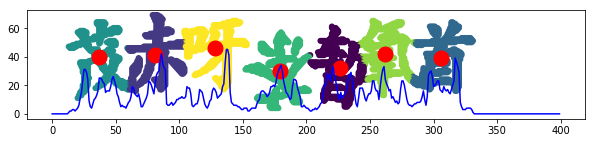

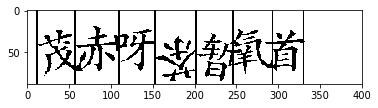

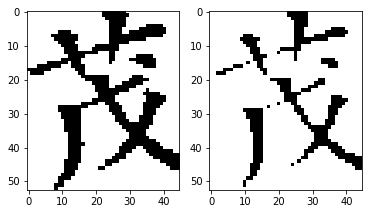

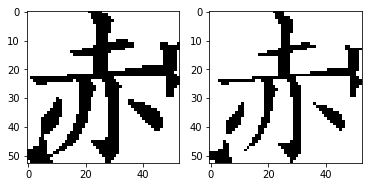

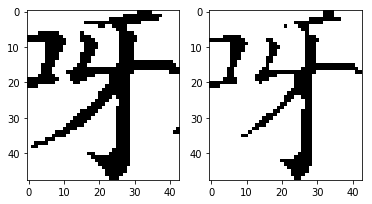

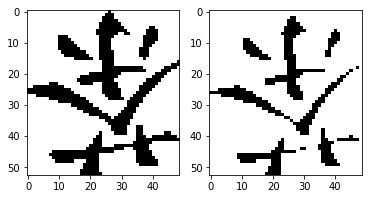

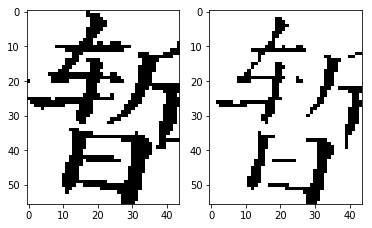

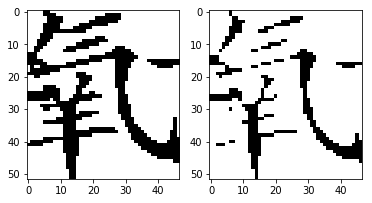

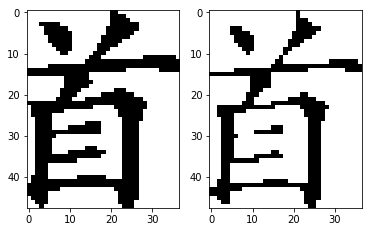

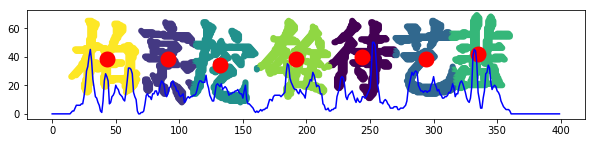

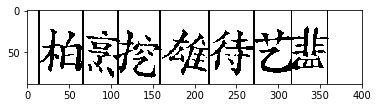

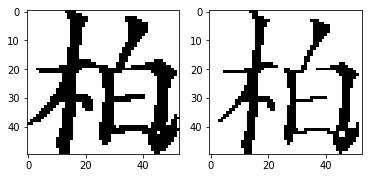

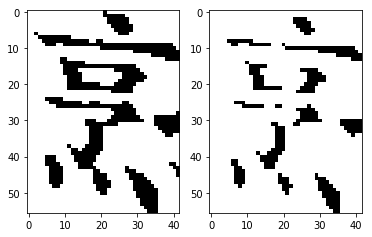

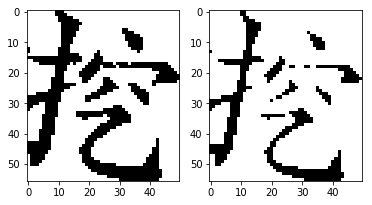

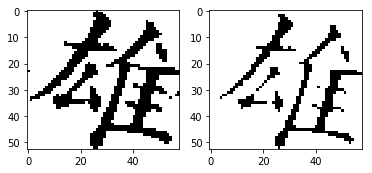

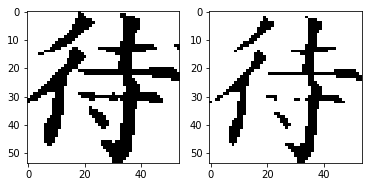

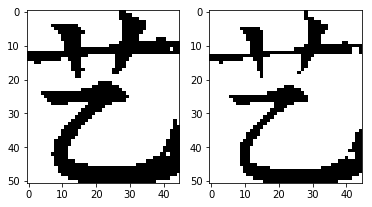

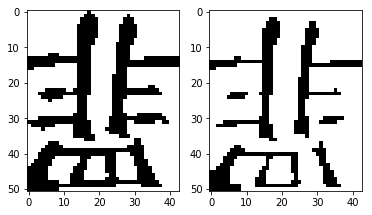

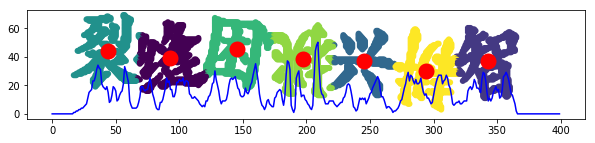

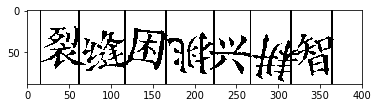

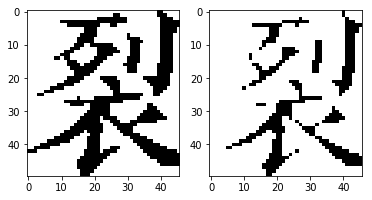

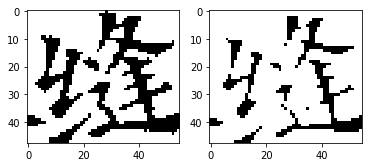

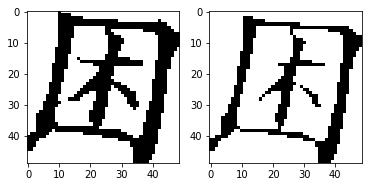

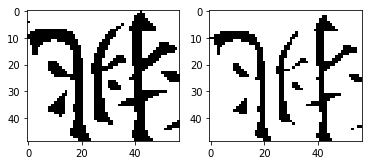

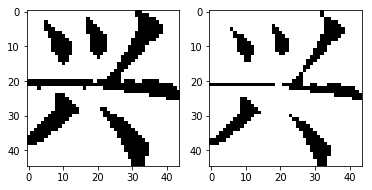

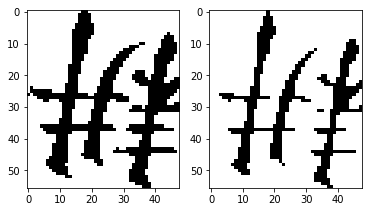

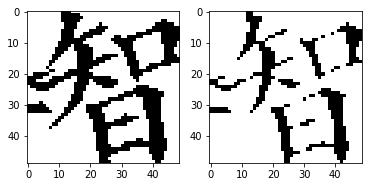

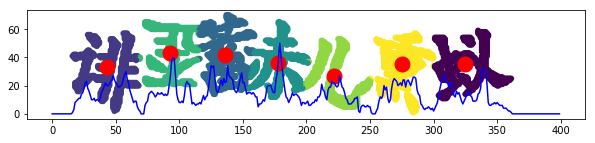

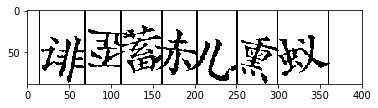

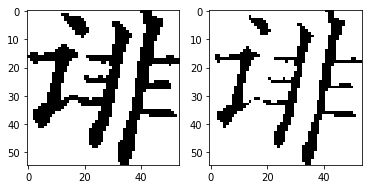

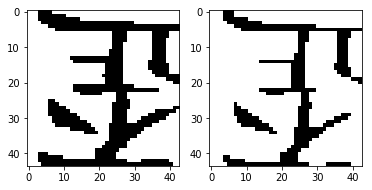

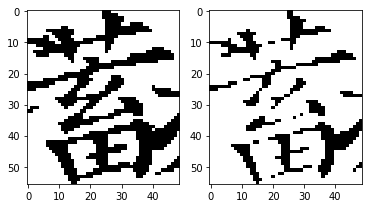

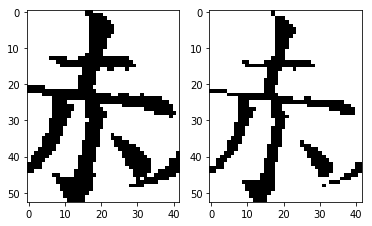

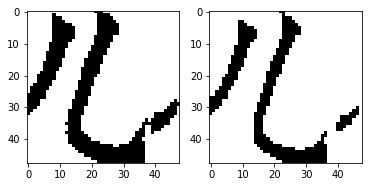

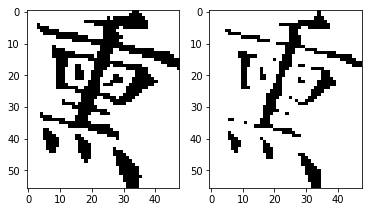

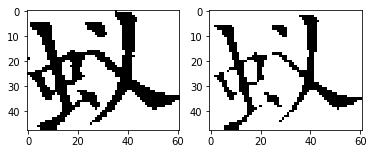

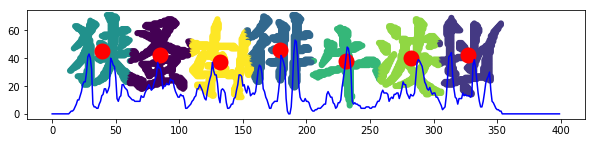

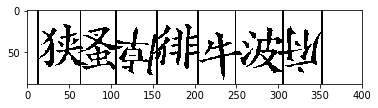

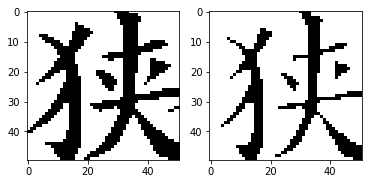

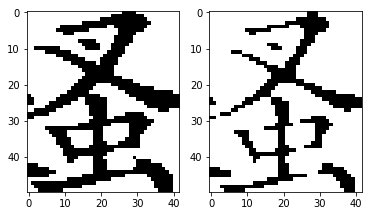

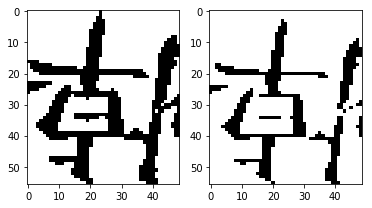

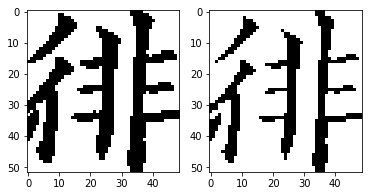

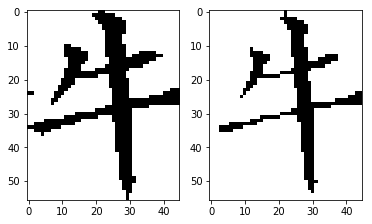

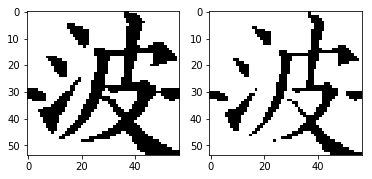

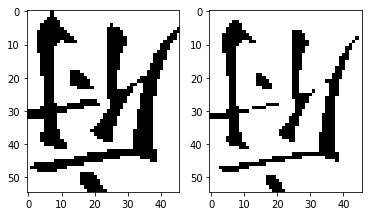

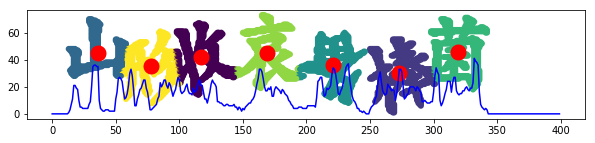

ValueError: attempt to get argmin of an empty sequence

In [113]:
class Captha2Word(object):
    
    def __init__(self, k,weight, height):
        self.weight = weight
        self.height = height
        self.k = k
    
    def run(self, img_path):
        img, PIL_img = self.get_img(img_path)
        centers = self.Kmeans(img)
        self.plot_centers(PIL_img,centers)
        self.test(img, centers)
    
    def test(self, raw_img, centers):
        # plt.imshow(img,cmap='gray') 
        # plt.show()
        img = raw_img.copy()
        count = np.sum(img == 0,axis= 0)
        left_boundary,right_boundary = 0,0
        for i in range(img.shape[1]):
            if count[i] != 0 :
                left_boundary = i
                break
        for i in range(img.shape[1]-1,-1,-1):
            if count[i] != 0 :
                right_boundary = i
                break
        # print(left, right)
        min_quarter = (right_boundary - left_boundary)//self.k//4
        min_weight = (right_boundary - left_boundary)//self.k *7 //8
        
        left = left_boundary + min_weight
        split_lines = [left_boundary]#字符之间的分割线位置
        for i in range(self.k - 1):
            right = centers[i+1][1] - min_quarter
            if left > right :
                minx = 0
            else :
                minx = np.argmin(count[left:right])
            line = left + minx 
            img = self.plot_line(img,line)
            left = line + min_weight
            split_lines.append(line)
        split_lines.append(right_boundary)
        img = self.plot_line(img,left_boundary)
        img = self.plot_line(img,right_boundary)
        plt.imshow(img,cmap='gray')
        plt.show()
        words = self.get_words(raw_img,split_lines)
    
    def get_words(self,img, split_lines):
        words = []
        for i in range(self.k):
            words.append(self.get_word(img[:,split_lines[i]:split_lines[i+1]]))
        return  words
    
    def get_word(self,img):
        count = np.sum(img==0, axis= 1)
        # print(count)
        up ,down = 0,0
        for i in range(img.shape[0]):
            if count[i] != 0:
                up = i
                break
        for i in range(img.shape[0]-1,-1,-1):
            if count[i] != 0:
                down = i
                break
        word = img[up:down,:] 
        word = self.delete_spot(word)
        word = cv2.resize(word, (self.height, self.weight))
        th,word= cv2.threshold(word,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        # word2 = cv2.dilate(word, kernel)
        # fig,ax = plt.subplots(1,2)
        # # print("thersold", th)
        # word2[word2<150] = 0
        # word2[word2>=150] = 255
        # ax[0].imshow(word, cmap="gray")
        # ax[1].imshow(word2, cmap="gray")
        # ax[2].imshow(word3, cmap="gray")
        plt.show()
        
    def delete_spot(self,img):
        pass
        
            
    def plot_line(self, img, line):
        img = img.copy()
        img[:,line-2:line] = 0
        return  img
            
        
        
    
    def Kmeans(self,img):
        X = self.get_black_point(img)
        plt.figure(figsize=(10,2))
        km = KMeans(n_clusters=self.k)
        y_pred = km.fit_predict(X)
        centers = km.cluster_centers_
        centers = np.asarray(centers,dtype = np.int16)
        centers = centers[np.argsort(centers[:,1])]
        # print(centers)
        plt.scatter(X[:,1], 88-X[:,0], c = y_pred, linewidths=0.01)
        plt.scatter(centers[:,1],88-centers[:,0],c='r', linewidths= 10)
        count = np.sum(img == 0,axis= 0)
        plt.plot(count,'b')
        plt.show()
        return  centers
        
    def plot_centers(self, PIL_img, centers):
        im = PIL_img.copy()
        bgdr = ImageDraw.Draw(im)
        for y, x in centers:
            bgdr.ellipse((x-3, y-3, x+3, y+3), fill ="red", outline ='red')
        # im.show()
        # print(im) 
        
    def split(self,img):
        pass
        
    def get_img(self,img_path):
        PIL_img = Image.open(img_path)
        img =np.asarray(PIL_img.convert("L"))#转化为灰度图像 
        img.setflags(write=1)
        # plt.imshow(img,cmap="gray")
        # plt.show()
        # uniques, counts = np.unique(img, return_counts=True)
        # print(uniques)
        # plt.scatter(uniques, counts)
        # plt.show()
        img[img<=150] = 0
        img[img>150]=255
        # plt.imshow(img,cmap="gray")
        # plt.show()
        
        return img, PIL_img.convert('RGB')
    
    def get_black_point(self, img):
        len = np.sum(img == 0)
        X = np.zeros((len,2))
        cnt = 0
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i][j] == 0:
                    X[cnt,0],X[cnt,1] = i,j
                    cnt =cnt +1
        return X
        
        
img_dir = r'.\CaptchaData'
k = 7#字符个数
weight =40
height = 40
get_word = Captha2Word(k,weight, height)
for img_name in (os.listdir(img_dir))[:]:
    img_path = os.path.join(img_dir, img_name)
    get_word.run(img_path)

In [66]:

im = cv2.imread(os.path.join(img_dir,'1.gif'),cv2.IMREAD_GRAYSCALE)
type(im)


NoneType